# Prototype for proper data handling

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
df = pd.read_csv('info/all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [4]:
df = df.drop(['pixelsx', 'pixelsy', 'size_bytes', 'source', 'title', 'artist_group', 'in_train', 'date'], axis=1)
df.head()

,artist,genre,style,new_filename
0,Barnett Newman,abstract,Color Field Painting,102257.jpg
1,Barnett Newman,abstract,Color Field Painting,75232.jpg
2,kiri nichol,NaN,Neoplasticism,32145.jpg
3,kiri nichol,NaN,Neoplasticism,20304.jpg
4,kiri nichol,NaN,Neoplasticism,836.jpg


In [5]:
print(len(df))
df = df.dropna()
print(len(df))

103250
101514


In [16]:
artist_s = df.groupby('artist').count().genre
artist_s.name = 'artist_count'
artist_df=  pd.DataFrame(artist_s)
artist_df.head()

,artist_count
artist,
Architect's visual,1
Capitain,1
François Leclerc du Tremblay,1
François Leclerc du Tremblay (detail),1
Fyodor Solntsev,37


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4fbe41f60>]],
      dtype=object)

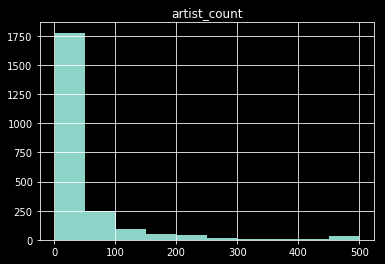

In [18]:
artist_df.hist()

In [21]:
genre_s = df.groupby('genre').count().artist
genre_s.name = 'genre_count'
genre_df = pd.DataFrame(genre_s)
genre_df.head()

,genre_count
genre,
abstract,9465
advertisement,82
allegorical painting,1033
animal painting,1552
battle painting,358


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4fbf3af28>]],
      dtype=object)

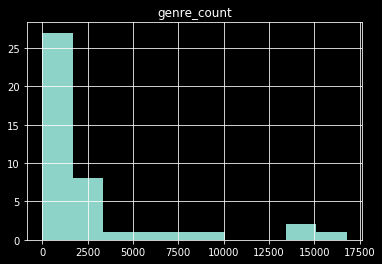

In [22]:
genre_df.hist()

In [23]:
style_s = df.groupby('style').count().artist
style_s.name = 'style_count'
style_df = pd.DataFrame(style_s)
style_df.head()

,style_count
style,
Abstract Art,973
Abstract Expressionism,2044
Academicism,971
Action painting,98
American Realism,277


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4fc8e6e48>]],
      dtype=object)

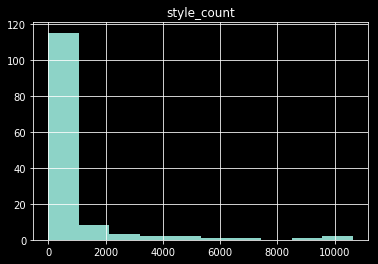

In [24]:
style_df.hist()

Not enough samples per class if we try to classify by painter -> genre and style.

In [45]:
df = df.drop('artist', axis=1)

In [25]:
genre_df.sort_values('genre_count', ascending=False)

,genre_count
genre,
portrait,16767
landscape,14959
genre painting,14217
abstract,9465
religious painting,7368
cityscape,5340
sketch and study,3626
illustration,3192
still life,3110


In [26]:
style_df.sort_values('style_count', ascending=False)

,style_count
style,
Impressionism,10638
Realism,10511
Romanticism,9244
Expressionism,6981
Post-Impressionism,5753
Art Nouveau (Modern),4887
Baroque,4394
Surrealism,4097
Symbolism,3471


In [30]:
style_df[style_df.style_count >= 1000]

,style_count
style,
Abstract Expressionism,2044
Art Informel,1253
Art Nouveau (Modern),4887
Baroque,4394
Cubism,1691
Early Renaissance,1350
Expressionism,6981
High Renaissance,1312
Impressionism,10638


In [33]:
genre_df[genre_df.genre_count >= 1000]

,genre_count
genre,
abstract,9465
allegorical painting,1033
animal painting,1552
cityscape,5340
design,2024
figurative,2201
flower painting,1590
genre painting,14217
illustration,3192


In [41]:
df[df['genre'].isin(genre_df[genre_df.genre_count >= 1000].index)]

,artist,genre,style,new_filename
0,Barnett Newman,abstract,Color Field Painting,102257.jpg
1,Barnett Newman,abstract,Color Field Painting,75232.jpg
5,Tosa Mitsuoki,mythological painting,Yamato-e,29855.jpg
6,Barnett Newman,abstract,Color Field Painting,62252.jpg
8,Barnett Newman,abstract,Color Field Painting,63861.jpg
9,Franz Richard Unterberger,cityscape,Romanticism,84512.jpg
11,Wolfgang Paalen,landscape,Surrealism,70944.jpg
12,Mabuse,religious painting,Northern Renaissance,59792.jpg
13,Utagawa Kunisada,landscape,Ukiyo-e,48138.jpg
14,Ivan Aivazovsky,marina,Romanticism,99442.jpg


In [46]:
common_df = df[(df['genre'].isin(genre_df[genre_df.genre_count >= 1000].index)) & (df['style'].isin(style_df[style_df.style_count >= 1000].index))]
common_df.head()

,genre,style,new_filename
9,cityscape,Romanticism,84512.jpg
11,landscape,Surrealism,70944.jpg
12,religious painting,Northern Renaissance,59792.jpg
13,landscape,Ukiyo-e,48138.jpg
14,marina,Romanticism,99442.jpg


In [47]:
pd.unique(common_df.genre)

array(['cityscape', 'landscape', 'religious painting', 'marina',
       'genre painting', 'still life', 'animal painting', 'self-portrait',
       'illustration', 'allegorical painting', 'portrait',
       'nude painting (nu)', 'mythological painting', 'flower painting',
       'design', 'symbolic painting', 'sketch and study', 'figurative',
       'abstract'], dtype=object)

Remove abstract, perhaps sketch and study. Merge portraits and self-portraits. Look at the rest to decide what to merge or remove. Train a classifier on this to see accuracy, look at confusion matrix and:
- look at confusion matrix, merge what seems to be similar (also based on domain knowledge)
- remove what the classifier is still bad at classifying.

In [54]:
def lookup(df, other_df, col):
    return other_df.loc[df[col]]

common_df['style_count'] = common_df.apply(lookup, axis=1, args=(style_df, 'style'))
common_df['genre_count'] = common_df.apply(lookup, axis=1, args=(genre_df, 'genre'))
common_df.head()

/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genre,style,new_filename,style_count,genre_count
9,cityscape,Romanticism,84512.jpg,9244,5340
11,landscape,Surrealism,70944.jpg,4097,14959
12,religious painting,Northern Renaissance,59792.jpg,2376,7368
13,landscape,Ukiyo-e,48138.jpg,1426,14959
14,marina,Romanticism,99442.jpg,9244,1801


In [ ]:
class PaintingsDataset(Dataset):
    """Dataset class to handle both genre and style label"""
    def __init__(self, csv_file, root_dir, tranform=None):
        self.data = pd.read(csv_file)
        self.root_dir = root_dir
        self.transform = tranform
        
        # do stuffs with the df here, in particular to have only data in root_dir
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data.loc[idx, 'new_filename'])
        image = io.imread(img_name)
        style = self.data['style'].loc[idx]
        genre = self.data['genre'].loc[idx]
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [67]:
df.head()

,genre,style,new_filename
0,abstract,Color Field Painting,102257.jpg
1,abstract,Color Field Painting,75232.jpg
5,mythological painting,Yamato-e,29855.jpg
6,abstract,Color Field Painting,62252.jpg
7,bird-and-flower painting,Ukiyo-e,49823.jpg


In [71]:
df[['genre', 'style']].loc[1]

genre                abstract
style    Color Field Painting
Name: 1, dtype: object